EXPERT SYSTEMS

Develop a simple expert system using rule-based reasoning/fuzzy logic.

Medical Explanation System
Multiple diseases with explanation and visualization

In [2]:
!pip install scikit-fuzzy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.8/920.8 kB 13.8 MB/s eta 0:00:00



Please answer the following questions with 'y'/'n', a temperature in Celsius for fever, or a cough intensity (1-10).
Do you have body ache? (y/n) y
Do you have chest pain? (y/n) n
Do you have cough? (y/n) y
On a scale of 1-10, how severe is your cough? 7
Do you have cough with phlegm? (y/n) n
Do you have fatigue? (y/n) y
Do you have fever? (y/n) 
Do you have headache? (y/n) n
Do you have high fever? (y/n) y
Do you have loss of smell? (y/n) n
Do you have loss of taste? (y/n) n
Do you have mild fever? (y/n) y
Do you have runny nose? (y/n) y
Do you have shortness of breath? (y/n) y
Do you have sneezing? (y/n) y
Do you have sore throat? (y/n) y

--------------------
DIAGNOSIS REPORT

Found 1 possible conditions:

1. Common Cold:
   Match: 100.0%
   Urgency: low (50.0/100)

   Symptoms present:
   ✓ runny nose
   ✓ sneezing
   ✓ sore throat
   ✓ cough
   ✓ mild fever

   Recommended treatments:
   • Rest
   • Antihistamines
   • Nasal decongestant

   Reasoning: Has runny nose; Has sneezin

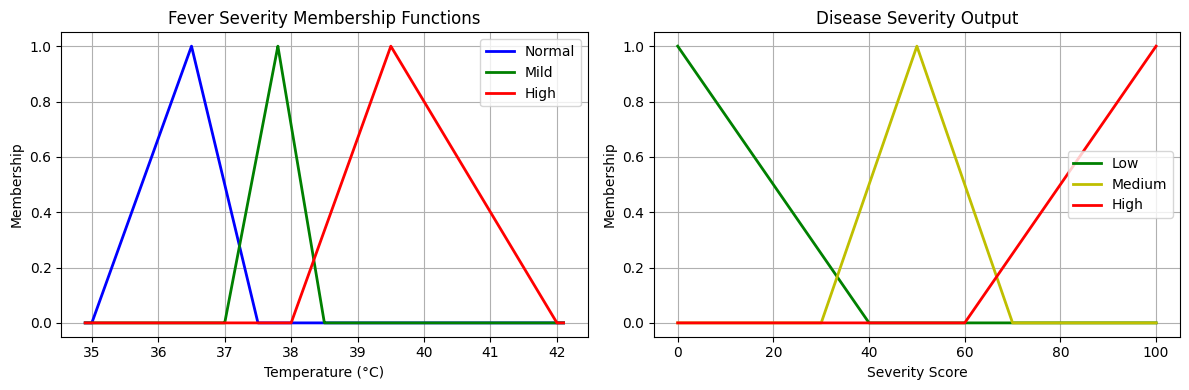

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import skfuzzy as fuzz
from skfuzzy import control as ctrl

class CompleteMedicalExpert:
    """Comprehensive medical diagnosis system"""

    def __init__(self):
        self.diseases = self._load_disease_database()
        self.fuzzy_ctrls = self._setup_fuzzy_controls()
        self.patient_history = []

    def _load_disease_database(self):
        """Comprehensive disease knowledge base"""
        return {
            'Influenza': {
                'symptoms': ['fever', 'cough', 'fatigue', 'body_ache', 'headache'],
                'required': ['fever', 'cough'],
                'risk_factors': ['elderly', 'chronic_illness', 'pregnancy'],
                'treatments': ['Antiviral (Tamiflu)', 'Rest', 'Fluids', 'Pain relievers'],
                'urgency': 'medium'
            },
            'Common Cold': {
                'symptoms': ['runny_nose', 'sneezing', 'sore_throat', 'cough', 'mild_fever'],
                'required': ['runny_nose'],
                'risk_factors': [],
                'treatments': ['Rest', 'Antihistamines', 'Nasal decongestant'],
                'urgency': 'low'
            },
            'COVID-19': {
                'symptoms': ['fever', 'cough', 'shortness_of_breath', 'loss_of_taste', 'loss_of_smell', 'fatigue'],
                'required': ['fever', 'cough'],
                'risk_factors': ['elderly', 'diabetes', 'heart_disease', 'obesity'],
                'treatments': ['Isolation', 'Medical consultation', 'Symptomatic treatment'],
                'urgency': 'high'
            },
            'Pneumonia': {
                'symptoms': ['high_fever', 'cough_with_phlegm', 'chest_pain', 'shortness_of_breath', 'fatigue'],
                'required': ['high_fever', 'cough_with_phlegm'],
                'risk_factors': ['smoking', 'lung_disease', 'weak_immune'],
                'treatments': ['Antibiotics', 'Hospitalization', 'Oxygen therapy'],
                'urgency': 'high'
            }
        }

    def _setup_fuzzy_controls(self):
        """Setup fuzzy logic control systems for symptom severity"""
        # Antecedents (Inputs)
        # Ensure critical points are explicitly in the universe for robustness against float precision issues
        fever_universe_points = np.unique(np.sort(np.concatenate([
            np.arange(34.9, 42.1, 0.1),  # Original range
            [35.0, 36.5, 37.5, 37.0, 37.8, 38.5, 38.0, 39.5, 42.0] # Explicit critical points
        ])))
        fever = ctrl.Antecedent(fever_universe_points, 'fever')

        # Consequents (Outputs)
        severity = ctrl.Consequent(np.arange(0, 101, 1), 'severity')

        # Membership functions for Fever
        fever['normal'] = fuzz.trimf(fever.universe, [35, 36.5, 37.5])
        fever['mild'] = fuzz.trimf(fever.universe, [37, 37.8, 38.5])
        fever['high'] = fuzz.trimf(fever.universe, [38, 39.5, 42])

        # Membership functions for Severity
        severity['low'] = fuzz.trimf(severity.universe, [0, 0, 40])
        severity['medium'] = fuzz.trimf(severity.universe, [30, 50, 70])
        severity['high'] = fuzz.trimf(severity.universe, [60, 100, 100])

        # Rules for Fever Severity
        rule1 = ctrl.Rule(fever['normal'], severity['low'])
        rule2 = ctrl.Rule(fever['mild'], severity['medium'])
        rule3 = ctrl.Rule(fever['high'], severity['high'])

        fever_ctrl = ctrl.ControlSystem([rule1, rule2, rule3])
        fever_sim = ctrl.ControlSystemSimulation(fever_ctrl)

        return {
            'fever': fever_sim
        }

    def _get_user_input(self):
        """Collects symptom information from the user"""
        symptoms = {s: False for disease_data in self.diseases.values() for s in disease_data['symptoms']}
        symptoms['fever_temp'] = None
        symptoms['cough_level'] = None

        print("\nPlease answer the following questions with 'y'/'n', a temperature in Celsius for fever, or a cough intensity (1-10).")

        for symptom in sorted(symptoms.keys()):
            if symptom == 'fever_temp' or symptom == 'cough_level':
                continue

            response = input(f"Do you have {symptom.replace('_', ' ')}? (y/n) ").lower()
            if response in ['y', 'yes', 'true']:
                symptoms[symptom] = True

                if symptom == 'fever':
                    temp_response = input("What is your temperature in Celsius? ")
                    if temp_response.replace('.', '').isdigit():
                        symptoms['fever_temp'] = float(temp_response)

                elif symptom == 'cough':
                    cough_intensity = input("On a scale of 1-10, how severe is your cough? ")
                    if cough_intensity.isdigit():
                        symptoms['cough_level'] = int(cough_intensity)

            elif response in ['n', 'no', 'false']:
                symptoms[symptom] = False
        return symptoms

    def _analyze_symptoms(self, symptoms):
        """Analyze symptoms against disease database"""
        results = []
        for disease, data in self.diseases.items():
            score = 0
            matched_symptoms = []
            explanation = []

            # Check required symptoms
            has_required = all(symptom in symptoms and symptoms[symptom] for symptom in data['required'])
            if not has_required:
                continue

            # Calculate matching score
            for symptom in data['symptoms']:
                if symptom in symptoms and symptoms[symptom]:
                    score += 1
                    matched_symptoms.append(symptom)
                    explanation.append(f"Has {symptom.replace('_', ' ')}")

            # Calculate percentage match
            match_percent = (score / len(data['symptoms'])) * 100

            # Assess urgency with fuzzy logic
            urgency_score = self._assess_urgency(symptoms, disease)

            results.append({
                'disease': disease,
                'match_percent': match_percent,
                'matched_symptoms': matched_symptoms,
                'explanation': explanation,
                'treatments': data['treatments'],
                'urgency': data['urgency'],
                'urgency_score': urgency_score
            })
        return sorted(results, key=lambda x: x['match_percent'], reverse=True)

    def _assess_urgency(self, symptoms, disease):
        """Fuzzy logic urgency assessment"""
        if 'fever_temp' in symptoms and self.fuzzy_ctrls and 'fever' in self.fuzzy_ctrls:
            ctrl_sim = self.fuzzy_ctrls['fever']
            if symptoms['fever_temp'] is not None:
                # Check if input is within the expected range of the fuzzy system
                # This uses the same range defined in _setup_fuzzy_controls for consistency
                if symptoms['fever_temp'] >= 34.9 and symptoms['fever_temp'] <= 42.0:
                    ctrl_sim.input['fever'] = symptoms['fever_temp']
                    ctrl_sim.compute()
                    # Check if 'severity' is in the output before accessing it to prevent KeyError
                    if 'severity' in ctrl_sim.output:
                        return ctrl_sim.output['severity']
                    else:
                        print(f"DEBUG: 'severity' key missing from fuzzy output for fever_temp={symptoms['fever_temp']}. Falling back to default urgency.")
                        return 50 # Fallback default if severity is not computed for some reason
                else:
                    print(f"DEBUG: Input fever_temp={symptoms['fever_temp']} is outside the configured fuzzy input range. Falling back to default urgency.")
                    return 50 # Default if input is out of fuzzy system's range
        return 50  # Default medium if fuzzy logic cannot be applied or fever temp is not provided

    def _generate_report(self, results, symptoms):
        """Generate comprehensive diagnosis report"""
        print("\n--------------------")
        print("DIAGNOSIS REPORT")
        if not results:
            print("\nNo matching diseases found.")
            print("Recommendation: Consult a doctor for accurate diagnosis.")
            return

        print(f"\nFound {len(results)} possible conditions:")
        for i, result in enumerate(results[:3], 1):  # Top 3
            print(f"\n{i}. {result['disease']}:")
            print(f"   Match: {result['match_percent']:.1f}%")
            print(f"   Urgency: {result['urgency']} ({result['urgency_score']:.1f}/100)")
            print(f"\n   Symptoms present:")
            for symptom in result['matched_symptoms'][:5]:  # Show top 5
                print(f"   ✓ {symptom.replace('_', ' ')}")
            print(f"\n   Recommended treatments:")
            for treatment in result['treatments']:
                print(f"   • {treatment}")
            print(f"\n   Reasoning: {'; '.join(result['explanation'][:3])}...")
            print("-"*40)

    def _visualize_fuzzy_sets(self):
        """Visualize fuzzy membership functions"""
        fig, axes = plt.subplots(1, 2, figsize=(12, 4))

        # Fever membership visualization (using the same robust universe)
        fever_universe_points = np.unique(np.sort(np.concatenate([
            np.arange(34.9, 42.1, 0.1),  # Original range
            [35.0, 36.5, 37.5, 37.0, 37.8, 38.5, 38.0, 39.5, 42.0] # Explicit critical points
        ])))
        fever_vis = fever_universe_points # Renamed to avoid conflict with ctrl.Antecedent

        normal = fuzz.trimf(fever_vis, [35, 36.5, 37.5])
        mild = fuzz.trimf(fever_vis, [37, 37.8, 38.5])
        high = fuzz.trimf(fever_vis, [38, 39.5, 42])

        axes[0].plot(fever_vis, normal, 'b', linewidth=2, label='Normal')
        axes[0].plot(fever_vis, mild, 'g', linewidth=2, label='Mild')
        axes[0].plot(fever_vis, high, 'r', linewidth=2, label='High')
        axes[0].set_title('Fever Severity Membership Functions')
        axes[0].set_xlabel('Temperature (°C)')
        axes[0].set_ylabel('Membership')
        axes[0].legend()
        axes[0].grid(True)

        # Severity output visualization
        severity = np.arange(0, 101, 1)
        low = fuzz.trimf(severity, [0, 0, 40])
        medium = fuzz.trimf(severity, [30, 50, 70])
        high_sev = fuzz.trimf(severity, [60, 100, 100])

        axes[1].plot(severity, low, 'g', linewidth=2, label='Low')
        axes[1].plot(severity, medium, 'y', linewidth=2, label='Medium')
        axes[1].plot(severity, high_sev, 'r', linewidth=2, label='High')
        axes[1].set_title('Disease Severity Output')
        axes[1].set_xlabel('Severity Score')
        axes[1].set_ylabel('Membership')
        axes[1].legend()
        axes[1].grid(True)

        plt.tight_layout()
        plt.savefig('fuzzy_visualization.png', dpi=150)
        print("\n✓ Fuzzy sets visualization saved as 'fuzzy_visualization.png'")

    def run(self):
        """Main method to run the expert system"""
        symptoms = self._get_user_input()
        results = self._analyze_symptoms(symptoms)
        self._generate_report(results, symptoms)
        self._visualize_fuzzy_sets()

# Example usage:
expert_system = CompleteMedicalExpert()
expert_system.run()


INTERACTIVE CAR DIAGNOSTIC EXPERT SYSTEM

Interactive version that asks user questions

In [6]:
import random
import time

class InteractiveCarDiagnosticExpert:
    """Interactive car diagnostic system using rule-based reasoning."""

    def __init__(self):
        self.symptoms = {}
        self.rules = self._load_diagnostic_rules()

    def _load_diagnostic_rules(self):
        """Define a simple rule-based knowledge base for car problems."""
        return {
            'Engine Cranks but Wont Start': {
                'causes': ['No fuel', 'Weak battery', 'Bad spark plugs', 'Faulty starter'],
                'questions': {
                    'Is the fuel tank empty?': 'no_fuel',
                    'Do the lights dim when trying to start?': 'weak_battery',
                    'Have the spark plugs been changed recently?': 'bad_spark_plugs'
                },
                'action': 'Check fuel, battery, and spark plugs.'
            },
            'Engine Misfires or Runs Roughly': {
                'causes': ['Bad spark plugs', 'Ignition coil issue', 'Fuel injector problem'],
                'questions': {
                    'Is the check engine light on?': 'check_engine_light',
                    'Any recent maintenance on spark plugs or coils?': 'recent_maintenance'
                },
                'action': 'Inspect ignition system components and fuel injectors.'
            },
            'Brakes Squealing/Grinding': {
                'causes': ['Worn brake pads', 'Worn rotors', 'Brake caliper issue'],
                'questions': {
                    'Does the noise happen when you apply brakes?': 'brake_noise',
                    'When were the brake pads last replaced?': 'brake_pad_age'
                },
                'action': 'Inspect brake pads and rotors immediately.'
            },
            'Overheating Engine': {
                'causes': ['Low coolant', 'Radiator issue', 'Thermostat stuck', 'Water pump failure'],
                'questions': {
                    'Is the coolant level low?': 'low_coolant',
                    'Is there steam coming from under the hood?': 'steam_from_hood'
                },
                'action': 'Check coolant level, radiator, and thermostat.'
            }
            # Add more rules here
        }

    def _ask_question(self, question_text):
        """Asks a yes/no question and returns True for 'y' and False for 'n'."""
        while True:
            response = input(f"{{question_text}} (y/n): ").lower().strip()
            if response in ['y', 'yes']:
                return True
            elif response in ['n', 'no']:
                return False
            else:
                print("Please answer 'y' or 'n'.")

    def _get_user_symptoms(self):
        """Collects initial symptoms from the user without specific questions yet."""
        print("\n--- Initial Symptom Collection ---")
        print("Please describe any issues you are experiencing (e.g., 'engine cranks', 'brakes squealing').")
        print("Type 'done' when you have listed all symptoms.")

        user_input_symptoms = []
        while True:
            symptom_input = input("Symptom: ").lower().strip()
            if symptom_input == 'done':
                break
            if symptom_input:
                user_input_symptoms.append(symptom_input)
        return user_input_symptoms

    def _map_input_to_known_symptoms(self, user_input_symptoms):
        """Maps user's natural language symptoms to predefined system symptoms."""
        mapped_symptoms = {}
        for user_symptom in user_input_symptoms:
            if 'engine' in user_symptom and 'cranks' in user_symptom and 'start' in user_symptom:
                mapped_symptoms['Engine Cranks but Wont Start'] = True
            if 'engine' in user_symptom and ('misfires' in user_symptom or 'rough' in user_symptom):
                mapped_symptoms['Engine Misfires or Runs Roughly'] = True
            if 'brakes' in user_symptom and ('squealing' in user_symptom or 'grinding' in user_symptom):
                mapped_symptoms['Brakes Squealing/Grinding'] = True
            if 'overheating' in user_symptom or ('engine' in user_symptom and 'hot' in user_symptom):
                mapped_symptoms['Overheating Engine'] = True
            # Add more mapping rules as the knowledge base grows
        return mapped_symptoms

    def start_diagnosis(self):
        """Starts the interactive diagnosis process."""
        print("\n--- Starting Car Diagnostic Expert System ---")
        user_initial_symptoms = self._get_user_symptoms()
        self.symptoms = self._map_input_to_known_symptoms(user_initial_symptoms)

        potential_problems = []

        for problem, data in self.rules.items():
            is_potential_problem = False
            # Check if any of the user's initial symptoms match the problem's description
            if problem in self.symptoms:
                is_potential_problem = True

            # Ask specific questions related to the problem if it's a potential match
            if is_potential_problem:
                print(f"\nLet's investigate: {problem}")
                all_questions_answered = True
                for question_text, symptom_key in data['questions'].items():
                    if not self._ask_question(question_text):
                        all_questions_answered = False
                        break # If a key question is answered 'no', move to next problem

                if all_questions_answered:
                    potential_problems.append(problem)

        self._generate_report(potential_problems)

    def run_quick_test(self):
        """Performs a quick diagnostic test for common, easily identifiable issues."""
        print("\n--- Running Quick Diagnostic Test ---")
        quick_symptoms = {}

        print("Does the check engine light come on?")
        quick_symptoms['check_engine_light'] = self._ask_question("Is the check engine light ON?")

        print("Are you hearing any unusual noises from the brakes?")
        quick_symptoms['brake_noise'] = self._ask_question("Are your brakes making squealing or grinding noises?")

        print("Is your car unusually hot after driving?")
        quick_symptoms['engine_hot'] = self._ask_question("Is the engine temperature gauge unusually high?")

        print("\n--- Quick Test Results ---")
        if quick_symptoms['check_engine_light']:
            print("Check engine light ON")
            print("  - Get OBD-II diagnostic scan")
        if quick_symptoms['brake_noise']:
            print("Brake issue detected")
            print("  - Immediate inspection recommended")
        if quick_symptoms['engine_hot']:
            print("Engine overheating detected")
            print("  - Check coolant and radiator.")

        if not any(quick_symptoms.values()):
            print("• No major issues detected in quick test")
            print("  - Continue with full diagnosis if problems persist")

    def _generate_report(self, problems):
        """Generates a diagnostic report based on identified problems."""
        print("\n---------------------------")
        print("CAR DIAGNOSTIC REPORT")
        print("---------------------------")

        if not problems:
            print("No specific major problems identified based on your input and further questions.")
            print("Recommendation: If issues persist, consult a professional mechanic for a comprehensive inspection.")
            return

        print("Potential Problems Identified:")
        for i, problem in enumerate(problems, 1):
            data = self.rules[problem]
            print(f"\n{i}. {{problem}}")
            print(f"   Possible Causes: {{', '.join(data['causes'])}}")
            print(f"   Recommended Action: {{data['action']}}")
            print("---------------------------")

# Main execution function
def run_interactive_car_diagnostic():
    """Run the interactive car diagnostic system"""
    expert = InteractiveCarDiagnosticExpert()

    print("SELECT DIAGNOSTIC MODE:")
    print("1. Full Interactive Diagnosis")
    print("2. Quick Diagnostic Test")
    print("3. Exit")

    while True:
        choice = input("\nEnter choice (1-3): ").strip()

        if choice == '1':
            expert.start_diagnosis()
            break
        elif choice == '2':
            expert.run_quick_test()
            response = input("\nRun full diagnosis? (yes/no): ").lower()
            if response in ['yes', 'y']:
                expert.start_diagnosis()
            break
        elif choice == '3':
            print("\nThank you for using Car Diagnostic Expert System!")
            break
        else:
            print("Invalid choice. Please enter 1, 2, or 3.")

    print("\nThank you for using our Car Diagnostic System!")
    print("Drive safely!")

# Run the system if the script is executed directly
if __name__ == "__main__":
    run_interactive_car_diagnostic()


SELECT DIAGNOSTIC MODE:
1. Full Interactive Diagnosis
2. Quick Diagnostic Test
3. Exit

Enter choice (1-3): 2

--- Running Quick Diagnostic Test ---
Does the check engine light come on?
{question_text} (y/n): y
Are you hearing any unusual noises from the brakes?
{question_text} (y/n): n
Is your car unusually hot after driving?
{question_text} (y/n): y

--- Quick Test Results ---
Check engine light ON
  - Get OBD-II diagnostic scan
Engine overheating detected
  - Check coolant and radiator.

Run full diagnosis? (yes/no): n

Thank you for using our Car Diagnostic System!
Drive safely!
